# Adverse Reaction Cluster of the COVID-19 Vaccine: Potential Clinical Prediction Tool

### Andrea Gomez, Dung Mai, Mariana Maroto
### Graduate Center, CUNY - Machine Learning CSCI 740 Spring 2021

Our application project clusters COVID-19 vaccine adverse reactions. The purpose of the project is having a detailed understanding of the common types of adverse reactions and  identifying which adverse reactions are in need of immediate care. This project suggests a two-step approach. First, we use an unsupervised machine learning algorithm (clustering) to segment adverse reactions into groups. This will give us the most common symptoms for each group. Second, using the vaccine reaction clusters, along with additional patient information (gender, age, allergies) and vaccine manufacturer information, we will predict the need of urgent medical care by using fatalities and hospital visits. 

The dataset is provided by the Vaccine Adverse Event Reporting System VAERS and contains reports about adverse events that may be associated with COVID-19 vaccines. The database we chose was the dataset provided for the current year 2021, considering that our goal is to explore reactions due to Covid vaccines. The data contains reports processed as of 3/26/2021. 

Dataset Source: VAERS - Vaccine Adverse Event Reporting System. Data Retrieve on 4/8/2021 https://vaers.hhs.gov/data/datasets.html

## 1. Data Cleaning

1.1 Read Datasets

In [111]:
%cd  /Users/MarianaMaroto/Desktop/MS in Data Science/74020 Machine Learning/ML Project/
import pandas as pd
all_data =  pd.read_csv('2021VAERSDATA.csv', sep=",", encoding = "ISO-8859-1")
symptoms_data = pd.read_csv('2021VAERSSYMPTOMS.csv', sep=",", encoding = "ISO-8859-1")
vax_data = pd.read_csv('2021VAERSVAX.csv', sep=",", encoding = "ISO-8859-1")

print('Main Dataset Size:'+ str(all_data.shape))
print('Symptoms Coded Dataset Size:' + str(symptoms_data.shape))
print('Vaccine Info Dataset Size:' + str(vax_data.shape))

C:\Users\MarianaMaroto\Desktop\MS in Data Science\74020 Machine Learning\ML Project
Main Dataset Size:(40348, 35)
Symptoms Coded Dataset Size:(56533, 11)
Vaccine Info Dataset Size:(40937, 8)


C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Symptoms coded dataset requires the most cleaning as each symptom should become a feature in dummy coding format. In original file, there could be more than one row for one individual if they presented more than 5 symptoms.

In [112]:
symptoms_data.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
3,916603,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
4,916604,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN


1.2 Stack Columns

In [113]:
# Remove SYMPTOMVERSION columns that are unecessary
symptoms_data = symptoms_data[symptoms_data.columns.drop(list(symptoms_data.filter(regex='SYMPTOMVERSION')))]

# Stack columns
symptoms_data['INDEX1'] = symptoms_data.index
#symptoms_data.head()
symptoms_data = pd.wide_to_long(symptoms_data, stubnames='SYMPTOM', i=['INDEX1'], j='NUMBER')
symptoms_data.reset_index(drop=True, inplace=True)
symptoms_data.head()

,VAERS_ID,SYMPTOM
0,916600,Dysphagia
1,916601,Anxiety
2,916602,Chest discomfort
3,916603,Dizziness
4,916604,Injection site erythema


1.3 Dummy Code Symptoms

In [114]:
# How many unique symptoms?
len(symptoms_data.SYMPTOM.unique())

4407

In [117]:
# concatenating by key
symptoms_data['SYMPTOM'] = symptoms_data['SYMPTOM'].astype(str)
dfs = symptoms_data
dfs['SYMTPOM_TEXT'] = dfs.groupby(['VAERS_ID'])['SYMPTOM'].transform(lambda x : ' '.join(x))
dfs.head()

,VAERS_ID,SYMPTOM,SYMTPOM_TEXT
0,916600,Dysphagia,Dysphagia Epiglottitis nan nan nan
1,916601,Anxiety,Anxiety Dyspnoea nan nan nan
2,916602,Chest discomfort,Chest discomfort Dysphagia Pain in extremity V...
3,916603,Dizziness,Dizziness Fatigue Mobility decreased nan nan
4,916604,Injection site erythema,Injection site erythema Injection site pruritu...


In [119]:
# Load the regular expression library
import re
# Remove nan
dfs['symptom_text_processed'] = \
dfs['SYMTPOM_TEXT'].map(lambda x: re.sub('nan', '', str(x)))
# Remove punctuation
dfs['symptom_text_processed'] = \
dfs['symptom_text_processed'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
# Convert the titles to lowercase
dfs['symptom_text_processed'] = \
dfs['symptom_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
dfs['symptom_text_processed'].head()

<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
<ipython-input-119-bcac151f8ad1>:8: DeprecationWarning: invalid escape sequence \.
  dfs['symptom_text_processed'].map(lambda x: re.sub('[,\.!?]', '', str(x)))


0                            dysphagia epiglottitis   
1                                  anxiety dyspnoea   
2    chest discomfort dysphagia pain in extremity v...
3               dizziness fatigue mobility decreased  
4    injection site erythema injection site pruritu...
Name: symptom_text_processed, dtype: object

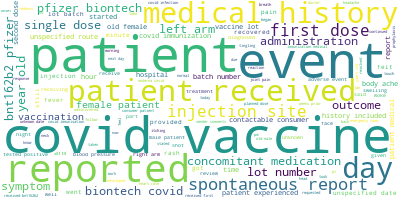

In [120]:
#Exploratory Analysis
# pip install wordcloud
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['symptom_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [121]:
import numpy
#numpy.random.bit_generator = numpy.random._bit_generator
import gensim
# pip install gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = dfs.symptom_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarianaMaroto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['dysphagia', 'epiglottitis']


In [122]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [123]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.131*"pain" + 0.055*"discomfort" + 0.048*"swelling" + 0.033*"abdominal" + '
  '0.033*"chest" + 0.031*"extremity" + 0.026*"throat" + 0.021*"peripheral" + '
  '0.019*"headache" + 0.018*"tightness"'),
 (1,
  '0.089*"rash" + 0.049*"dizziness" + 0.043*"paraesthesia" + 0.042*"feeling" + '
  '0.037*"skin" + 0.036*"pruritus" + 0.030*"oral" + 0.025*"hypoaesthesia" + '
  '0.024*"urticaria" + 0.021*"abnormal"'),
 (2,
  '0.039*"tomogram" + 0.039*"computerised" + 0.039*"imaging" + '
  '0.038*"magnetic" + 0.038*"resoce" + 0.033*"abnormal" + 0.031*"normal" + '
  '0.030*"test" + 0.028*"head" + 0.025*"disorder"'),
 (3,
  '0.129*"pain" + 0.099*"headache" + 0.091*"chills" + 0.086*"pyrexia" + '
  '0.073*"fatigue" + 0.058*"nausea" + 0.041*"myalgia" + 0.027*"arthralgia" + '
  '0.025*"vomiting" + 0.024*"extremity"'),
 (4,
  '0.140*"test" + 0.078*"cov" + 0.078*"sars" + 0.061*"negative" + '
  '0.038*"positive" + 0.027*"covid" + 0.018*"virus" + 0.015*"blood" + '
  '0.014*"abnormal" + 0.014*"influenza"'

# Trying LDA From VAERS Data Itself 

In [6]:
all_data =  pd.read_csv('2021VAERSDATA.csv', sep=",", encoding = "ISO-8859-1")

C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
all_data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na


In [8]:
# Select only columns needed for 
df = all_data[['VAERS_ID','SYMPTOM_TEXT']]
df.head()

,VAERS_ID,SYMPTOM_TEXT
0,916600,Right side of epiglottis swelled up and hinder...
1,916601,Approximately 30 min post vaccination administ...
2,916602,"About 15 minutes after receiving the vaccine, ..."
3,916603,"extreme fatigue, dizziness,. could not lift my..."
4,916604,"Injection site swelling, redness, warm to the ..."


In [9]:
# Load the regular expression library
import re
# Remove punctuation
df['symptom_text_processed'] = \
df['SYMPTOM_TEXT'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
# Convert the titles to lowercase
df['symptom_text_processed'] = \
df['symptom_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['symptom_text_processed'].head()

C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    right side of epiglottis swelled up and hinder...
1    approximately 30 min post vaccination administ...
2    about 15 minutes after receiving the vaccine t...
3    extreme fatigue dizziness could not lift my le...
4    injection site swelling redness warm to the to...
Name: symptom_text_processed, dtype: object

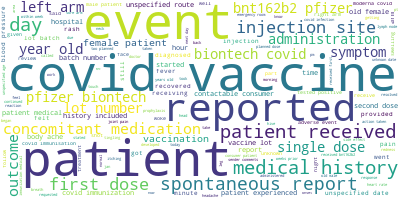

In [10]:
#Exploratory Analysis
# pip install wordcloud
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['symptom_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
import numpy
#numpy.random.bit_generator = numpy.random._bit_generator
import gensim
# pip install gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.symptom_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\MarianaMaroto\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\MarianaMaroto\Anacon

['right', 'side', 'epiglottis', 'swelled', 'hinder', 'swallowing', 'pictures', 'taken', 'benadryl', 'tylenol', 'taken']


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1)]


In [13]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"pain" + 0.022*"injection" + 0.019*"headache" + 0.019*"arm" + '
  '0.019*"fever" + 0.018*"site" + 0.016*"day" + 0.014*"body" + 0.014*"chills" '
  '+ 0.014*"aches"'),
 (1,
  '0.047*"patient" + 0.030*"covid" + 0.026*"vaccine" + 0.026*"dose" + '
  '0.016*"received" + 0.013*"reported" + 0.012*"first" + 0.011*"feb" + '
  '0.011*"jan" + 0.010*"unknown"'),
 (2,
  '0.039*"patient" + 0.020*"vaccine" + 0.014*"pt" + 0.009*"covid" + '
  '0.007*"minutes" + 0.006*"dose" + 0.006*"left" + 0.006*"pain" + '
  '0.006*"received" + 0.006*"reported"'),
 (3,
  '0.025*"patient" + 0.009*"like" + 0.009*"felt" + 0.009*"chest" + '
  '0.009*"blood" + 0.009*"vaccine" + 0.009*"fever" + 0.008*"started" + '
  '0.008*"pressure" + 0.008*"arm"'),
 (4,
  '0.043*"patient" + 0.030*"covid" + 0.018*"vaccine" + 0.017*"received" + '
  '0.015*"dose" + 0.015*"events" + 0.014*"jan" + 0.012*"reported" + '
  '0.012*"report" + 0.011*"pfizer"'),
 (5,
  '0.020*"patient" + 0.014*"arm" + 0.013*"vaccine" + 0.013*"reported" +